In [6]:
import torch

print(torch.cuda.is_available())
print(torch.backends.mps.is_available())

False
True


In [ ]:
import torch
import torch.nn.functional as F
from ts_inverse.models import JitGRU_Predictor, JitSeq2Seq_Predictor
from ts_inverse.attack_time_series_utils import SMAPELoss
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from ts_inverse.datahandler import get_datasets

# df = pd.read_csv("./data/LondonSmartMeter/london_smart_meters_dataset_without_missing_values_first_30_consumers.csv", index_col='Time', parse_dates=['Time'])
# train_datasets, val_datasets, test_datasets = get_datasets("london_smartmeter", normalize='minmax', columns=df.columns[:1], train_stride=24, observation_days=1, future_days=1, validation_stride=24)
train_dataset = None

df = pd.read_csv("../data/Electricity370/LD2011_2014_first_40_consumers.csv", index_col="Time", parse_dates=["Time"])
train_datasets, val_datasets, test_datasets = get_datasets(
    "electricity_370", normalize="minmax", columns=df.columns[:1], train_stride=24, observation_days=1, future_days=1, validation_stride=24
)

# train_dataset = train_datasets[0]

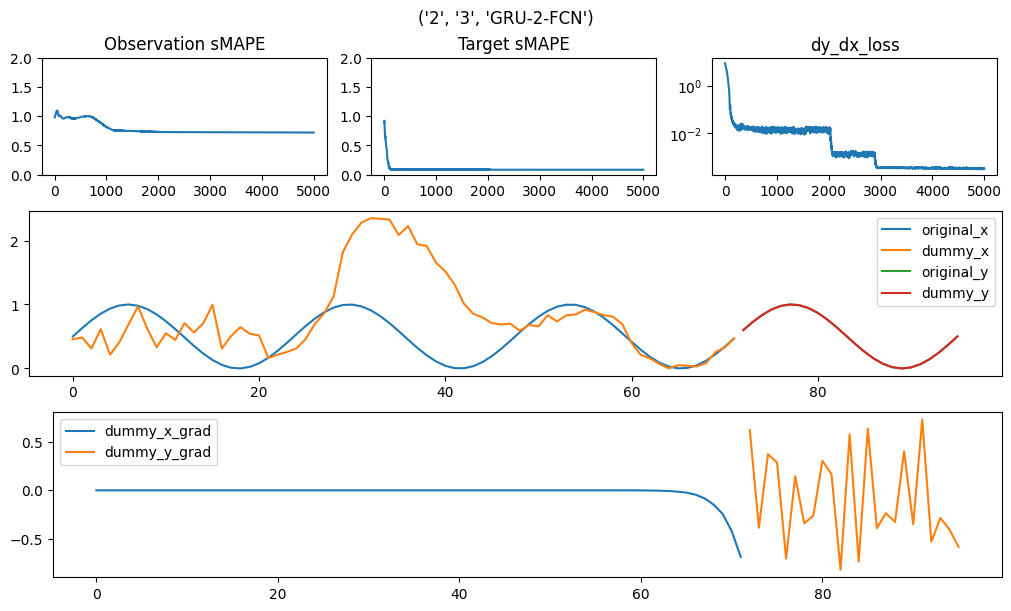

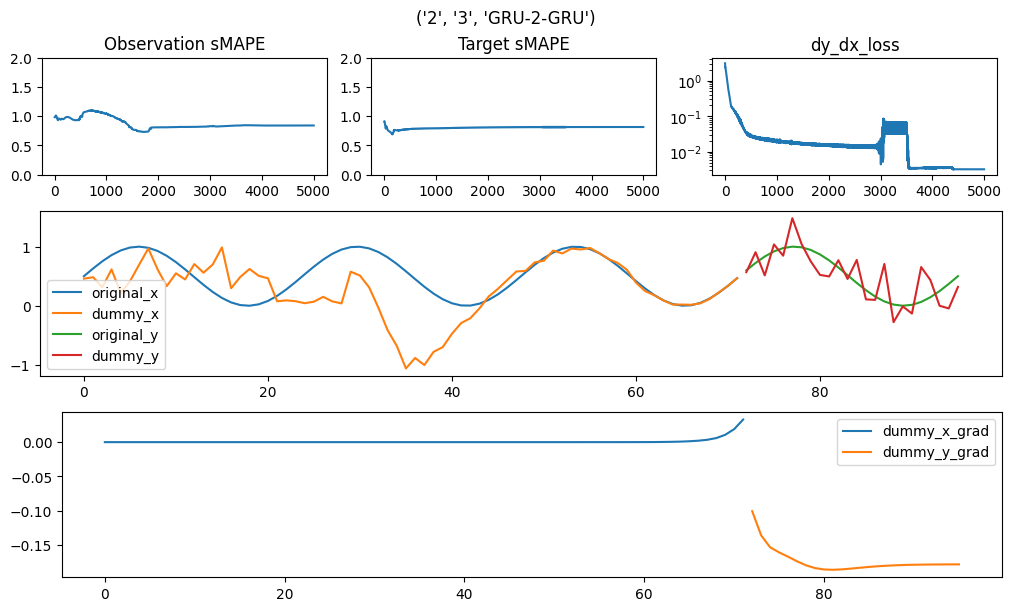

In [4]:
def plot_original_dummy(fig, ax, o_x, o_y, d_x, d_y):
    t = torch.arange(0, o_x.shape[1] + o_y.shape[1])
    ax.plot(t.numpy()[: o_x.shape[1]], o_x[0, :, 0].numpy(), label="original_x")
    ax.plot(t.numpy()[: o_x.shape[1]], d_x[0, :, 0].detach().numpy(), label="dummy_x")

    ax.plot(t.numpy()[o_x.shape[1] :], o_y[0, :].numpy(), label="original_y")
    ax.plot(t.numpy()[o_x.shape[1] :], d_y[0, :].detach().numpy(), label="dummy_y")
    ax.legend()


batch_size = 1
seed = 10
input_data_based_on_observation_days = []
target_days = 1
steps_per_day = 24

if train_dataset is None:
    for sin_period in [2]:  # torch.linspace(1, 4, 3):
        for observation_days in [3]:  # range(1, 5):
            torch.manual_seed(seed)
            np.random.seed(seed)
            total_days = observation_days + target_days
            t = torch.linspace(0, sin_period * np.pi * total_days, steps_per_day * total_days)
            original_x = torch.sin(t[: steps_per_day * observation_days]).view(
                1, steps_per_day * observation_days, 1
            )  # + torch.randn(1, 24 * observation_days, 1) * 0.1
            original_y = torch.sin(t[steps_per_day * observation_days :]).view(1, steps_per_day * target_days)  # + torch.randn(1, 24 * target_days) * 0.1

            # stack batch_size times
            original_x = original_x.repeat(batch_size, 1, 1)
            original_y = original_y.repeat(batch_size, 1)

            # minmax original_x and original_y
            original_x = (original_x - original_x.min()) / (original_x.max() - original_x.min())
            original_y = (original_y - original_y.min()) / (original_y.max() - original_y.min())

            # dummy_x, dummy_y = torch.ones_like(original_x) * 0.5, torch.ones_like(original_y) * 0.5
            dummy_x, dummy_y = torch.rand_like(original_x), torch.rand_like(original_y)

            input_data_based_on_observation_days.append(
                (sin_period, observation_days, original_x.clone(), original_y.clone(), dummy_x.clone(), dummy_y.clone())
            )
else:
    original_x, original_y = train_dataset[0]
    original_x, original_y = original_x.clone()[:, [0]].unsqueeze(0), original_y.clone()[:, 0].unsqueeze(0)
    dummy_x, dummy_y = torch.rand_like(original_x), torch.rand_like(original_y)
    input_data_based_on_observation_days.append((train_dataset.name, 1, original_x.clone(), original_y.clone(), dummy_x.clone(), dummy_y.clone()))

results_dictionary = {}


def draw_plot_of_attack_results(original_x, original_y, dummy_x, dummy_y, results_dictionary, exp_key, dummy_x_gradients, dummy_y_gradients):
    fig = plt.figure(layout="constrained", figsize=(10, 6))
    subfigs = fig.subfigures(3, 1, wspace=0.1)

    loss_fig = subfigs[0]
    axes = loss_fig.subplots(1, 3, sharex=True)
    loss_fig.suptitle(f"{exp_key}")
    axes[0].plot(results_dictionary[exp_key]["dummy_x_smape"], label="dummy_x_smape")
    axes[0].set_title("Observation sMAPE")
    axes[0].set_ylim([0, 2])
    axes[1].plot(results_dictionary[exp_key]["dummy_y_smape"], label="dummy_y_smape")
    axes[1].set_title("Target sMAPE")
    axes[1].set_ylim([0, 2])
    axes[2].plot(results_dictionary[exp_key]["dy_dx_loss"], label="dy_dx_loss")
    axes[2].set_title("dy_dx_loss")
    axes[2].set_yscale("log")

    reconstructions_fig = subfigs[1]
    ax = reconstructions_fig.subplots(1, 1)
    plot_original_dummy(reconstructions_fig, ax, original_x, original_y, dummy_x, dummy_y)

    grads_fig = subfigs[2]
    ax_grads = grads_fig.subplots(1, 1)
    t = torch.arange(0, original_x.shape[1] + original_y.shape[1])
    ax_grads.plot(t.numpy()[: original_x.shape[1]], dummy_x_gradients[0, :, 0].detach().numpy(), label="dummy_x_grad")
    ax_grads.plot(t.numpy()[original_x.shape[1] :], dummy_y_gradients[0, :].detach().numpy(), label="dummy_y_grad")
    ax_grads.legend(loc="best")

    plt.savefig(f"../out/00_gru_experiments/{'__'.join(map(str, exp_key))}.png")
    plt.show()


for sin_period, observation_days, o_x, o_y, d_x, d_y in input_data_based_on_observation_days:
    input_size = 24 * observation_days
    for model_name in ["GRU-2-FCN", "GRU-2-GRU"]:
        exp_key = (str(sin_period), str(observation_days), model_name)
        torch.manual_seed(seed)
        np.random.seed(seed)

        original_x, original_y, dummy_x, dummy_y = o_x.clone(), o_y.clone(), d_x.clone(), d_y.clone()
        dummy_x.requires_grad_(True)
        dummy_y.requires_grad_(True)
        if model_name == "GRU-2-FCN":
            model = JitGRU_Predictor(features=[0], hidden_size=64, input_size=original_x.shape[1], output_size=original_y.shape[1])
        elif model_name == "GRU-2-GRU":
            model = JitSeq2Seq_Predictor(features=[0], hidden_size=64, input_size=original_x.shape[1], output_size=original_y.shape[1])

        original_out = model(original_x)
        original_y_loss = F.mse_loss(original_out.squeeze(-1), original_y)
        original_y_loss.backward()
        original_dy_dx = [param.grad.clone() for param in model.parameters()]

        dummy_optimizer = torch.optim.Adam([dummy_x, dummy_y], lr=0.01)
        dummy_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dummy_optimizer, "min", patience=500, factor=0.1)

        dummy_x_gradients, dummy_y_gradients = torch.zeros_like(dummy_x), torch.zeros_like(dummy_y)

        for i in range(5000):
            dummy_optimizer.zero_grad()

            dummy_out = model(dummy_x)
            dummy_y_loss = F.mse_loss(dummy_out.squeeze(-1), dummy_y)
            dummy_dy_dx = torch.autograd.grad(dummy_y_loss, model.parameters(), create_graph=True)
            dy_dx_loss = torch.tensor(0.0)
            total_loss, dummy_norm, orig_norm = torch.tensor(0.0), torch.tensor(0.0), torch.tensor(0.0)
            for g_i, (d_g, o_g) in enumerate(zip(dummy_dy_dx, original_dy_dx)):
                dy_dx_loss += (d_g - o_g).abs().sum()

            dy_dx_loss.backward()

            # dummy_x.grad.sign_()

            dummy_x_gradients = dummy_x.grad.clone()
            dummy_y_gradients = dummy_y.grad.clone()

            dummy_optimizer.step()

            # if i % 2 == 0:
            #     dummy_x.data.clamp_(0, 1)
            #     dummy_y.data.clamp_(0, 1)

            dummy_scheduler.step(dy_dx_loss)

            if exp_key not in results_dictionary:
                results_dictionary[exp_key] = {
                    "dummy_x_smape": [SMAPELoss(original_x, dummy_x).item()],
                    "dummy_y_smape": [SMAPELoss(original_y, dummy_y).item()],
                    "dy_dx_loss": [dy_dx_loss.item()],
                }
            else:
                results_dictionary[exp_key]["dummy_x_smape"].append(SMAPELoss(original_x, dummy_x).item())
                results_dictionary[exp_key]["dummy_y_smape"].append(SMAPELoss(original_y, dummy_y).item())
                results_dictionary[exp_key]["dy_dx_loss"].append(dy_dx_loss.item())
                results_dictionary[exp_key]["reconstructions"] = [
                    dummy_x.clone(),
                    dummy_y.clone(),
                    original_x.clone(),
                    original_y.clone(),
                    dummy_x_gradients.clone(),
                    dummy_y_gradients.clone(),
                ]

        draw_plot_of_attack_results(original_x, original_y, dummy_x, dummy_y, results_dictionary, exp_key, dummy_x_gradients, dummy_y_gradients)

In [5]:
# # sort dictionary based on the last dummy_x_smape
# sorted_results_dictionary = {k: v for k, v in sorted(results_dictionary.items(), key=lambda item: item[1]['dummy_x_smape'][-1])}
# for i, (key, value) in enumerate(sorted_results_dictionary.items()):
#     print(key)
#     print('dy_dx_loss:', value['dy_dx_loss'][-1])
#     print('dummy_x_smape:', value['dummy_x_smape'][-1])
#     print('dummy_y_smape:', value['dummy_y_smape'][-1])
#     fig = plt.figure(layout='constrained', figsize=(10, 6))
#     subfigs = fig.subfigures(2, 1, wspace=0.1)

#     loss_fig = subfigs[0]
#     axes = loss_fig.subplots(1, 3, sharex=True)
#     loss_fig.suptitle(f"{exp_key}")
#     axes[0].plot(results_dictionary[exp_key]['dummy_x_smape'], label='dummy_x_smape')
#     axes[0].set_ylim([0, 2])
#     axes[1].plot(results_dictionary[exp_key]['dummy_y_smape'], label='dummy_y_smape')
#     axes[1].set_ylim([0, 2])
#     axes[2].plot(results_dictionary[exp_key]['dy_dx_loss'], label='dy_dx_loss')
#     loss_fig.legend()

#     reconstructions_fig = subfigs[1]
#     ax = reconstructions_fig.subplots(1, 1)

#     plot_original_dummy(reconstructions_fig, ax, original_x, original_y, dummy_x, dummy_y)
#     plt.show()
#     print('---\n')
#     if i > 10:
#         break